# Analysis of ALeague Data
Extension of previous work on NRL data, but this time using Aleague Data. This shows that once you have a reasonable workflow, it's relatively easy to run the same sort of analysis but on varying datasets. If motivated, one could put significant time into developing a customisable workflow which shares a common base between models, but then allows flexibility to accomodate the nuances involved in each sport. I.e. we expect each sport to have different predictors of success, although likely to share some in common too but with different weightings.

## 1. Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utils_aleague # here we just package up all the utility functions we used

# Scikit-Learn deprecation warnings, turn off.
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## 2. Data IO

We'll be using historical A League data obtained from: http://www.aussportsbetting.com/data/ Which comes with the disclaimer "The following data set may contain errors.  It is a condition of use that you do not rely upon the information provided in this spreadsheet when making wagering decisions. Please verify everything for yourself."

In [3]:
aleague_raw = pd.read_csv("a_league_matches.csv")

## 3. Data Cleaning

Here we're going to clean the data into a more basic format, and include only the data we deem relevant for analysis.

In [22]:
aleague_raw.head(5)

,id,year,team1,score1,score2,team2,Play Off Game?,Home Odds,Draw Odds,Away Odds,Bookmakers Surveyed,Date,Kick-off (local)
0,0,2016,Western Sydney,2,2,Newcastle Jets,N,1.78,3.88,4.26,14,23-Oct-16,19:00
1,1,2016,Wellington Phoenix,0,1,Sydney FC,N,3.61,3.60,2.00,14,23-Oct-16,19:00
2,2,2016,Adelaide Utd,1,2,Melbourne Victory,N,2.47,3.44,2.78,14,22-Oct-16,19:20
3,3,2016,Central Coast Mariners,0,1,Brisbane Roar,N,4.36,4.03,1.73,14,22-Oct-16,17:35
4,4,2016,Melbourne City,2,3,Perth Glory,N,1.50,4.56,5.78,14,21-Oct-16,19:50


In [4]:
aleague_df = aleague_raw[["year", "team1", "score1", "score2", "team2"]]

In [23]:
aleague_df.head(5)

,year,team1,score1,score2,team2
0,2016,Western Sydney,2,2,Newcastle Jets
1,2016,Wellington Phoenix,0,1,Sydney FC
2,2016,Adelaide Utd,1,2,Melbourne Victory
3,2016,Central Coast Mariners,0,1,Brisbane Roar
4,2016,Melbourne City,2,3,Perth Glory


## 4. Basic Exploration
We're going to utilise some utility functions to extra out relevant information on the dataset. These functions allow us to derive out some basic match statistics.

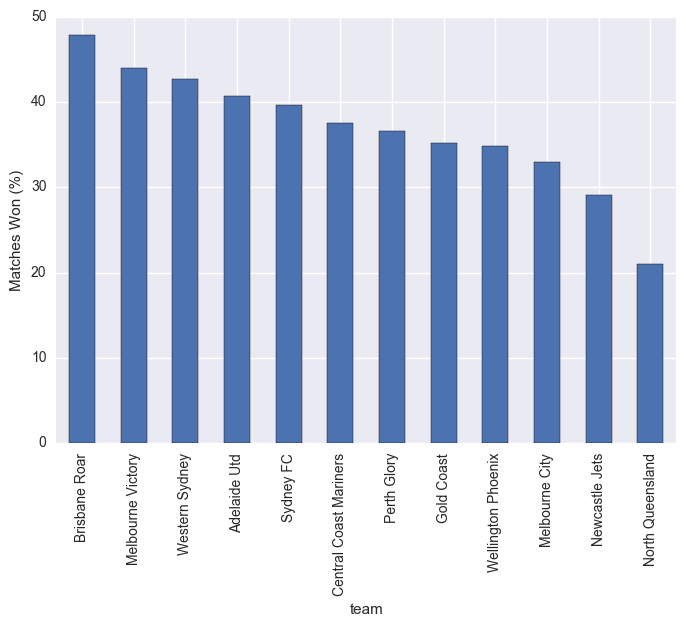

In [5]:
matches = utils_aleague.get_matches()
stats = utils_aleague.get_team_stats()
stats["matches_won_percent"].sort_values(ascending=False).plot(kind="bar")
plt.ylabel("Matches Won (%)")
plt.show()

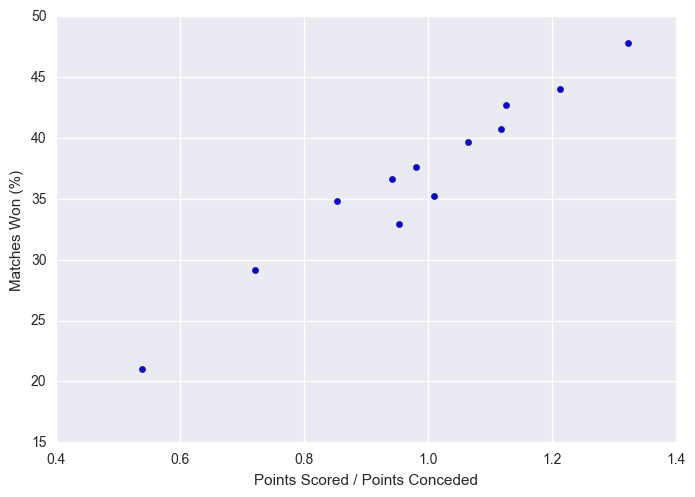

In [6]:
plt.scatter(x = stats["scored/conceded"], y = stats["matches_won_percent"])
plt.xlabel("Points Scored / Points Conceded")
plt.ylabel("Matches Won (%)")
plt.show()

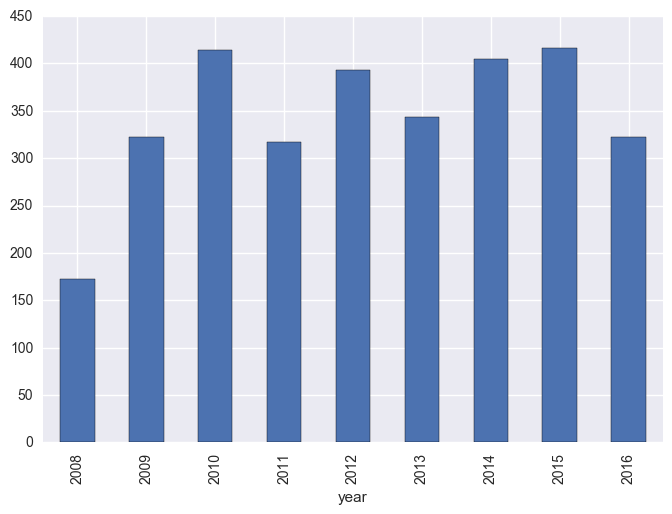

In [7]:
matches["total_scored"] = matches["score1"] + matches["score2"]
matches.groupby("year").sum()["total_scored"].plot(kind="bar")
plt.show()

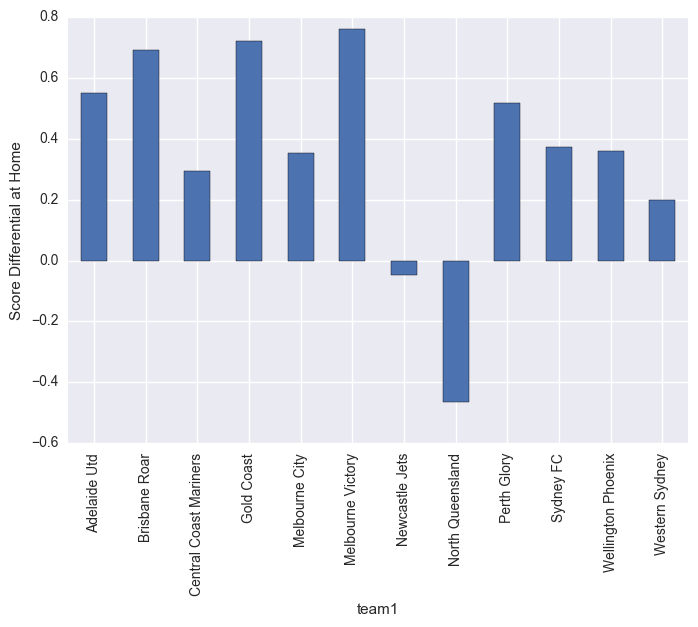

In [8]:
matches.groupby("team1").mean()["score_diff"].plot(kind="bar")
plt.ylabel("Score Differential at Home")
plt.show()

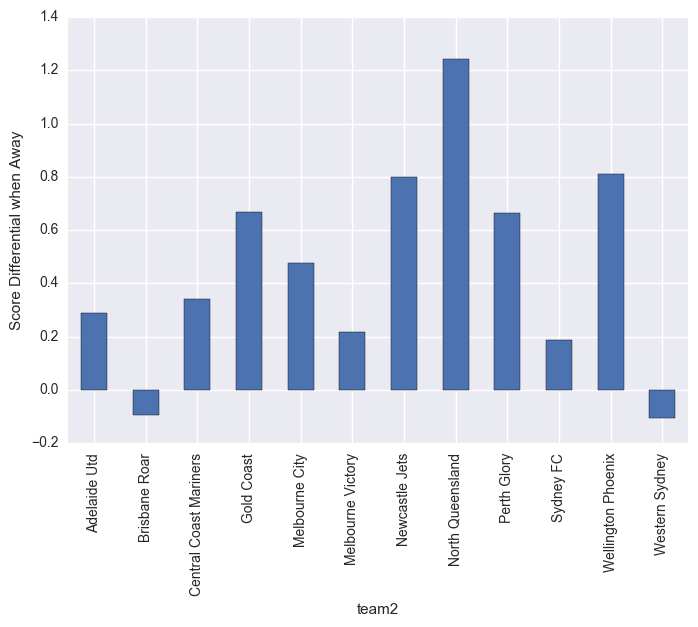

In [9]:
matches.groupby("team2").mean()["score_diff"].plot(kind="bar")
plt.ylabel("Score Differential when Away")
plt.show()

## 5. Prediction Definition
Given our previous indication, we'll now seek to apply some very basic, rudimentary machine learning techniques to see if we can beat a coin-flip at guessing the winner of a match. 

Note that we're not using any podium finishes here, unlike in the NRL data.. expected effect is that this will reduce our prediction ability, likely quite significantly.

In [20]:
input_features = ["year",
                  "matches_won_percent",
                  "matches_won_percent_2"]

output_feature = "winner"
matches = utils_aleague.get_matches(with_team_stats=True)
inputs, outputs = utils_aleague.extract_samples(matches, input_features, output_feature)
normalizer, inputs = utils_aleague.normalize(inputs)

train_inputs, train_outputs, test_inputs, test_outputs = utils_aleague.split_samples(inputs, outputs)


###### 6. Basic Models 

In [12]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score

In [14]:
k_fold = KFold(n_splits = 10)
clf = SVC()
clf.fit(train_inputs, train_outputs)
print("SVC Score: ",clf.score(test_inputs, test_outputs))

clf_forest = RandomForestClassifier(n_estimators=100)
clf_forest.fit(train_inputs, train_outputs)
print("Random Forest Score: ", clf_forest.score(test_inputs, test_outputs))

SVC Score:  0.508333333333
Random Forest Score:  0.408333333333


We see compared to the NRL data, the predictions here are noticeable worse. This is likely due to not including any data on final placings in the season.

## 8. Neural Nets

We can also explore the use of Keras here. We will use a very basic approach and give some demonstrative examples of how to apply Keras to this type of data.

In [15]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop, SGD
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import StratifiedKFold

Using TensorFlow backend.


In [16]:
X = np.array(inputs)
y = np.array(outputs).astype(float)
y[y == 2] = 0 # We treat 2 as a loss, 1 as a win. Normalise this so that 0 = loss, 1 = win.

kfold = StratifiedKFold(n_splits=10)
cvscores = []
history = []

In [17]:
for train, test in kfold.split(X, y):
  # create model
    model = Sequential()
    model.add(Dense(12, activation='relu',input_dim=len(input_features) ))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    opt = SGD(lr=0.01) 
    model.compile(loss = "binary_crossentropy", optimizer = opt, metrics = ["accuracy"])
    # Fit the model
    history.append(model.fit(X[train], y[train], nb_epoch=20, batch_size=128, verbose=0))
    # evaluate the model
    scores = model.evaluate(X[test], y[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

acc: 51.79%
acc: 50.00%
acc: 45.05%
acc: 40.54%
acc: 56.76%
acc: 54.95%
acc: 45.05%
acc: 52.25%
acc: 53.15%
acc: 47.75%


As expected, the results aren't significantly improved on what we obtained with SVC and RF. Rather, we see that we typically see results in the range of 50-60%. Using this validation, we can now fit a model and draw some conclusions.

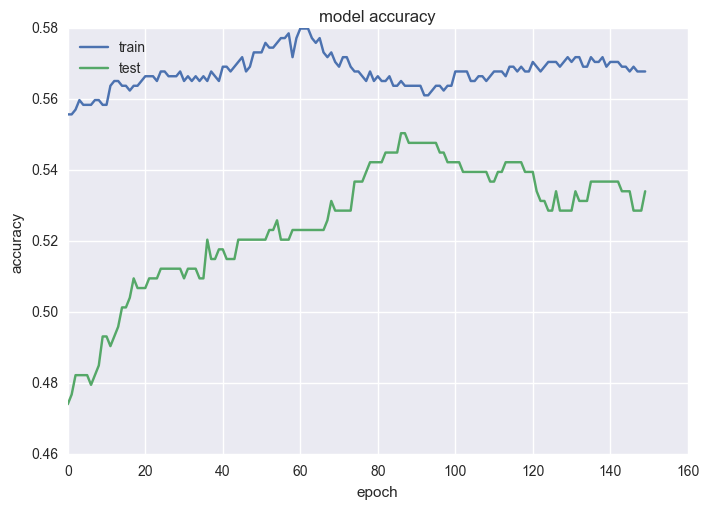

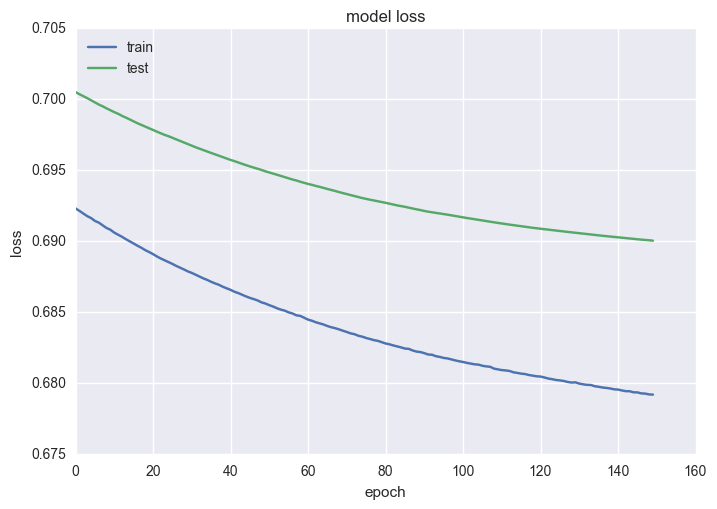

In [18]:
history = model.fit(X, y, validation_split=0.33, nb_epoch=150, batch_size=128, verbose=0)

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_28 (Dense)                 (None, 12)            48          dense_input_10[0][0]             
____________________________________________________________________________________________________
dense_29 (Dense)                 (None, 8)             104         dense_28[0][0]                   
____________________________________________________________________________________________________
dense_30 (Dense)                 (None, 1)             9           dense_29[0][0]                   
Total params: 161
Trainable params: 161
Non-trainable params: 0
____________________________________________________________________________________________________


## 9. Application to Prediction
We can apply the exact same function as in the NRL notebook, to obtain the exact same prediction ability. Of course this is all dependent on how well your model functions, and as we see above, our model doesn't function that well.


In [19]:
def predict(year, team1, team2):
    inputs = []
    
    for feature in input_features:
        from_team_2 = '_2' in feature
        feature = feature.replace('_2', '')
        
        if feature in stats.columns.values:
            team = team2 if from_team_2 else team1
            value = stats.loc[team, feature]
        elif feature == 'year':
            value = year
        else:
            raise ValueError("Don't know where to get feature: " + feature)
            
        inputs.append(value)
    
    inputs = np.array([normalizer.transform(inputs)])
    result = model.predict(inputs)
    
    if result == 0.5:
        return 'tie'
    elif result > 0.5:
        return team1
    elif result < 0.5:
        return team2
    else:
        return "Unknown result: " + str(result)
    
print(predict(2013,"Melbourne Victory", "Western Sydney"))


Western Sydney
